# A battery dispatch simulaiton with linear programming

In this project, a 100 kW, 2-hour battery is simulated over a whole year span to operate in NYC market to maximize the profit based on Locational Marginal Price (LMP). 

This project is inspired by a previous work done by Stephen Klosterman at https://www.steveklosterman.com/energy-arbitrage/, with two major modifications though. (1) In the original work by Stephen, simulaiton was done on a daily basis assuming we only know the LMP for the next 36 hours at a time. In this project, simulation was done semi-annually instead. The goal is to explore if there is additional profit that can be earned or different dispatch patterns if we have an accurate annual LMP forecast before hand. When I first tried annual simulations, the PULP tool I used often failed, which might be related to number of variables and constraints. Thus I devided it into two semi-annual simulations and combined them. (2) In this project I added a binary variable for discharge status and a constraint for number of discharges. This can be of interest in real practice because too frequent discharges can make batteries degrade and retire early. 

In [1]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import time

# Import price data

The raw data can be found in Stephen's work. Here I'm simply importing a lighter and cleaner dataset where only NYC data is selected.

In [2]:
lmp = pd.read_csv('lmp.csv',index_col=0)
lmp = lmp[:8760]

In [3]:
lmp.tail()

,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
2020-04-29 19:00:00,N.Y.C.,61761,19.94,1.09,-7.96
2020-04-29 20:00:00,N.Y.C.,61761,21.53,1.28,-7.09
2020-04-29 21:00:00,N.Y.C.,61761,17.34,1.28,-3.39
2020-04-29 22:00:00,N.Y.C.,61761,15.42,1.11,-3.82
2020-04-29 23:00:00,N.Y.C.,61761,14.68,0.52,-9.20


In [4]:
lmp.index = pd.to_datetime(lmp.index)

Text(0.5, 1.0, 'Locational Marginal Price ($/MWH)')

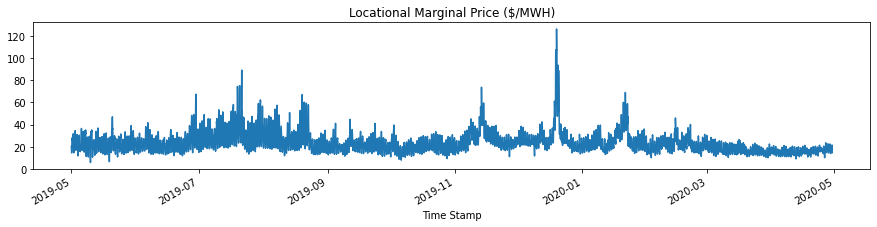

In [5]:
plt.subplots(figsize=(15,3)) 
lmp['LBMP ($/MWHr)'].plot()
plt.title('Locational Marginal Price ($/MWH)')

In [6]:
len(lmp)

8760

The LMP data starts from May 1, 2019 and end on April 29, 2020. It consists of 365 days (8760 hours)

# Define a Battery class and several methods needed for building a Linear Programming problem

In [7]:
class Battery():
    
    def __init__(self,
                 time_horizon,
                 max_discharge_power_capacity,
                 max_charge_power_capacity):
        
        """initiate the class and set up decision variables"""
        self.time_horizon = time_horizon
        
        # Variable 1 - charge in each hour
        self.charge =  pulp.LpVariable.dicts(
            "charging_power",
            (f'c_t_{i}' for i in range(0,time_horizon)),
            lowBound=0, upBound=max_charge_power_capacity,
            cat='Continuous')
        
        # Variable 2 - discharge in each hour
        self.discharge =  pulp.LpVariable.dicts(
            "discharging_power",
            (f'd_t_{i}' for i in range(0,time_horizon)),
            lowBound=0, upBound=max_discharge_power_capacity,
            cat='Continuous')
        
        # Variable 3 (Binary) - discharge status in each hour
        self.discharge_status = pulp.LpVariable.dicts(
            "discharge_status",
            (f'ds_t_{i}' for i in range(0,time_horizon)),
            cat='Binary')

    def set_objective(self, lmp_df):
        
        """set up objective function: (sum of charge cost + sum of discharge payment)"""

        try:
            assert len(lmp_df) == self.time_horizon
        except:
            print('Error: need one price for each hour in time horizon')
        
        self.model = pulp.LpProblem("battery_dispatch", pulp.LpMaximize)
    

        self.model += \
        pulp.LpAffineExpression(
            [(self.charge[f'c_t_{i}'], -lmp_df.iloc[i].values) for i in range(self.time_horizon)]) +\
        pulp.LpAffineExpression(
            [(self.discharge[f'd_t_{i}'], lmp_df.iloc[i].values) for i in range(self.time_horizon)])
        
    def add_storage_constraints(self,
                                efficiency,
                                min_capacity,
                                discharge_energy_capacity,
                                initial_level):
        
        # constraint 1 - at any hour, the battery level >= minimum capacity
    
        for hour_of_sim in range(1,self.time_horizon+1):     
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge[f'c_t_{i}'], efficiency) for i in range(hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[f'd_t_{i}'] for i in range(hour_of_sim))\
            >= min_capacity
            
        # constraint 2 - at any hour, the battery level <= maximum capacity

        for hour_of_sim in range(1,self.time_horizon+1):
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge[f'c_t_{i}'], efficiency) for i in range(hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[f'd_t_{i}'] for i in range(hour_of_sim))\
            <= discharge_energy_capacity         
            

    def add_discharge_constraints(self,max_discharge_count,discharge_energy_capacity):

        # constraint 3 - at any hour, if discharge status is OFF, force discharge not exceed 0; 
        # if discharge status is ON, force discharge not exceed max discharge capacity
        
        for i in range(self.time_horizon):

            self.model += self.discharge[f'd_t_{i}'] <= max_discharge_power_capacity \
            * self.discharge_status[f'ds_t_{i}']  
            
            
        # constraint 4 - total number of discharges <= pre-defined limit
        
        self.model += \
        pulp.lpSum(
            [self.discharge_status[f'ds_t_{i}'] for i in range(self.time_horizon)]) \
        <= max_discharge_count  
        
    def solve_model(self):
        
        """Solve the optimization problem"""
        
        self.model.solve()
        
        #Show a warning if an optimal solution was not found
        if pulp.LpStatus[self.model.status] != 'Optimal':
            print('Warning: ' + pulp.LpStatus[self.model.status])
            
    def collect_output(self,lmp_df,initial_level):
        
        """put all values of interest in a pandas dataframe"""
        
        df = lmp_df.copy()
        df['charge'] = [-self.charge[f'c_t_{i}'].varValue for i in range(self.time_horizon)]
        df['discharge'] = [self.discharge[f'd_t_{i}'].varValue for i in range(self.time_horizon)]
        df['discharge_status'] = [self.discharge_status[f'ds_t_{i}'].varValue for i in range(self.time_horizon)]
        df['state_of_energy'] = initial_level+(-df['charge']*efficiency).cumsum()-df['discharge'].cumsum()

        return df

# Run the simulation for first half year

In [8]:
max_discharge_power_capacity = 100 #(kW)
max_charge_power_capacity = 100 #(kW)
discharge_energy_capacity = 200 #(kWh)
initial_level = discharge_energy_capacity/2
efficiency = 0.85 #unitless

time_horizon_1 = int(365/2)*24
max_discharge_count = int(time_horizon_1/24*2)
lmp_df=lmp[['LBMP ($/MWHr)']][:time_horizon_1]
min_capacity=0

In [9]:
# Create a battery instance and set up the variables
battery = Battery(time_horizon_1,max_discharge_power_capacity,max_charge_power_capacity)

In [10]:
#Track simulation time
tic = time.time()

#Set objective function
battery.set_objective(lmp_df)

#Set constraints
battery.add_storage_constraints(efficiency, min_capacity, discharge_energy_capacity, initial_level)

battery.add_discharge_constraints(max_discharge_count,discharge_energy_capacity)

#Solve the optimization problem and collect output
battery.solve_model()

df_1 = battery.collect_output(lmp_df,initial_level)

toc = time.time()

print('Total simulation time: ' + str(toc-tic) + ' seconds')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mike/opt/anaconda3/envs/Bootcamp_Capstone_3/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/nr/1ym4q_1j1tq_84n001mm1shw0000gq/T/d3bcf130e58b42659465bea9a158531b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/nr/1ym4q_1j1tq_84n001mm1shw0000gq/T/d3bcf130e58b42659465bea9a158531b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13110 COLUMNS
At line 38211271 RHS
At line 38224377 BOUNDS
At line 38237482 ENDATA
Problem MODEL has 13105 rows, 13104 columns and 38180688 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 616063 - 22.16 seconds
Cgl0004I processed model has 8736 rows, 13104 columns (4368 integer (4368 of which binary)) and 19096894 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.6
Cbc0038I Pass   1: (101

# Run the simulation for second half year

In [11]:
initial_level = df_1.iloc[-1,-1]
time_horizon_2 = 8760-time_horizon_1
lmp_df=lmp[['LBMP ($/MWHr)']][time_horizon_1:]
max_discharge_count = int(time_horizon_2/24*2)

In [12]:
# Create a battery instance and set up the variables
battery = Battery(time_horizon_2,max_discharge_power_capacity,max_charge_power_capacity)

In [13]:
#Track simulation time
tic = time.time()

#Set objective function
battery.set_objective(lmp_df)

#Set constraints
battery.add_storage_constraints(efficiency, min_capacity, discharge_energy_capacity, initial_level)

battery.add_discharge_constraints(max_discharge_count,discharge_energy_capacity)

#Solve the optimization problem and collect output
battery.solve_model()

df_2 = battery.collect_output(lmp_df,initial_level)

toc = time.time()

print('Total simulation time: ' + str(toc-tic) + ' seconds')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/mike/opt/anaconda3/envs/Bootcamp_Capstone_3/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/nr/1ym4q_1j1tq_84n001mm1shw0000gq/T/30de8505f9374795a8d442ce7b0f9783-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/nr/1ym4q_1j1tq_84n001mm1shw0000gq/T/30de8505f9374795a8d442ce7b0f9783-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13182 COLUMNS
At line 38632039 RHS
At line 38645217 BOUNDS
At line 38658394 ENDATA
Problem MODEL has 13177 rows, 13176 columns and 38601288 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 368646 - 14.57 seconds
Cgl0004I processed model has 8785 rows, 13176 columns (4392 integer (4392 of which binary)) and 19307232 elements
Cbc0038I Initial state - 10 integers unsatisfied sum - 2.8
Cbc0038I Pass   1: (77

Total simulation time: 1016.7546529769897 seconds


# Concat two simulations and explore the result

In [14]:
df = pd.concat([df_1,df_2])
df.head()

,LBMP ($/MWHr),charge,discharge,discharge_status,state_of_energy
Time Stamp,,,,,
2019-05-01 00:00:00,20.32,-0.000000,0.0,0.0,100.0
2019-05-01 01:00:00,17.09,-0.000000,0.0,0.0,100.0
2019-05-01 02:00:00,14.89,-0.000000,0.0,0.0,100.0
2019-05-01 03:00:00,14.49,-17.647059,0.0,0.0,115.0
2019-05-01 04:00:00,14.49,-100.000000,0.0,0.0,200.0


First of all, let's see if the operations meet our constraints.

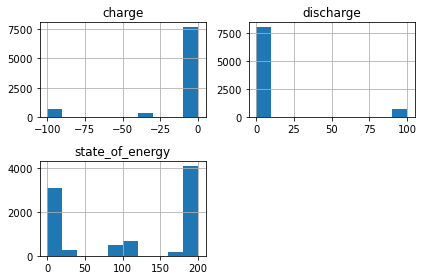

In [15]:
df[['charge','discharge','state_of_energy']].hist()
plt.tight_layout()

Great! Looks like the discharge, charge and state of energy are all within bounds. Let's calculate the annual dispatch hours. 

In [16]:
df.discharge_status.sum()

730.0

The battery is dispatched for 730 hours during the year, which is exactly 2 hours/day * 365 days per constraint. But is it really dispatched 2 hours each day?

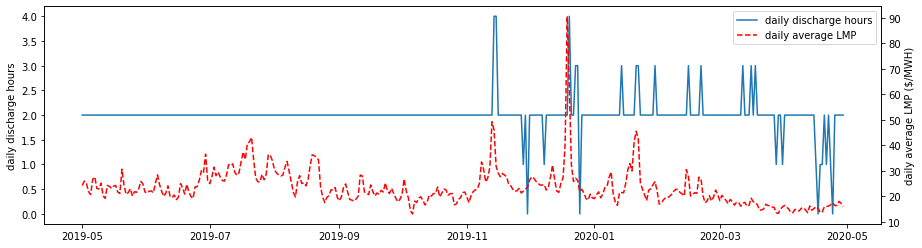

In [17]:
fig, ax1 = plt.subplots(figsize=(15,4))
ax2 = ax1.twinx()
ax1.plot(df.resample('D').discharge_status.sum(),label='daily discharge hours')
ax2.plot(df.resample('D')['LBMP ($/MWHr)'].mean(),'r--',label='daily average LMP')

ax1.set_ylabel('daily discharge hours')
ax2.set_ylabel('daily average LMP ($/MWH)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

It turns out that for most days it's dispatched for 2 hours during that day, but at times it's dispatched for 4 hours or 0 hour. Obviously a semi-annual simulation plans the battery operation differently than daily simulation as shown in Steven's work 

What about the annual profit?

In [18]:
(df['LBMP ($/MWHr)']*(df['discharge']+df['charge'])).sum()/1000

984.5819987786421

OK it's slightly higher than the original work by Steven. It's expected to be so because we assume the LMP is known for a much longer time span. Let's zoom in to see how exactly the battery is dispatched during a high-profit day. 

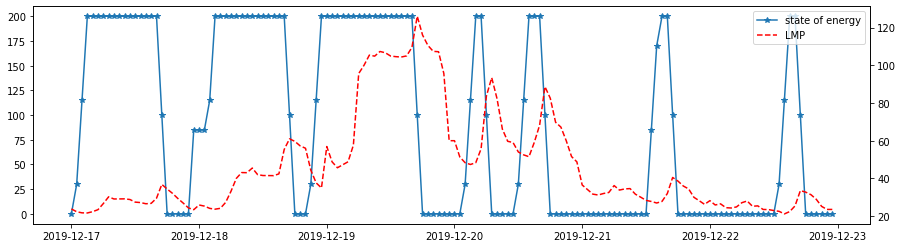

In [19]:
plot_df = df['2019-12-17':'2019-12-22']
fig, ax1 = plt.subplots(figsize=(15,4))
ax2 = ax1.twinx()
ax1.plot(plot_df['state_of_energy'],'-*',label='state of energy')
ax2.plot(plot_df['LBMP ($/MWHr)'],'r--',label='LMP')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

As it shows, on 12/20 two charge-discharge cycles took place, which is not typical. This is likely due to a special price curve on that day with two peaks and large fluctuations.

# Conclusions

1. Assuming we know the LMP for a whole year period, doing semi-annual simulations seem to increase the profit than daily simulations. 
2. This also changes how the battery is dispatched. It may not be dispatched at all during certain days just so more dispatches can happen on other days to maximize the profit while not exceeding dispatch limit

# Future work

1. It'll be worth exploring how the result may vary with a single whole-year simulation instead of two semi-annual simulations. 
2. Adding peak demand reduction as part of the objective function may further increase the profit and affect the dispatch patterns